In [174]:
import numpy as np
data = np.load("exercise1.npz")
XA1 = data['XA1']
yA1 = data['yA1']
XA2 = data['XA2']
yA2 = data['yA2']

XB1 = data['XB1']
yB1 = data['yB1']
XB2 = data['XB2']
yB2 = data['yB2']
data.close()

In [199]:
from sklearn import linear_model
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


def evaluate_performance(X,y,cv_):
    reg = linear_model.LinearRegression()
    cv_results = cross_validate(reg, X, y, cv=cv_, scoring=('r2','neg_mean_squared_error'))
    sorted(cv_results.keys())
    ['fit_time', 'score_time', 'test_score']
    test_mean_squared_error = -np.mean(cv_results['test_neg_mean_squared_error'])
    test_r2 = np.mean(cv_results['test_r2'])
    return test_mean_squared_error, test_r2



In [252]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def random_forest_feature_selection(X, y, nr_ests = 10):
    rf = RandomForestRegressor(n_estimators = nr_ests, max_depth = 5, min_samples_leaf = 5)
    rf.fit(X, y)
    feature_importance = rf.feature_importances_
    sorted_features = sorted(range(len(feature_importance)), key=lambda k: feature_importance[k])
    #sorted_features = sorted_features.reverse()
    return sorted_features

In [518]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

def sequential_feature_selector(X,y,nrFeatures,forward_):
    nrFeatures_left = nrFeatures if forward_ else 1
    lr = LinearRegression()
    sfs = SFS(lr, 
              k_features=nrFeatures_left, 
              forward=forward_, 
              floating=False, 
              scoring='neg_mean_squared_error',
              cv=10)
    sfs = sfs.fit(X, y)
    #features = sfs.subsets_[nrFeatures].get("feature_idx", "")
    features = []
    for i in range(1,nrFeatures): 
        perv_features = list(sfs.subsets_[i].get("feature_idx", ""))
        these_features = list(sfs.subsets_[i+1].get("feature_idx", ""))
        #print(perv_features)
        #print(these_features)
        next_feature = [x for x in these_features if x not in perv_features]
        #print(next_feature)
        features.append(next_feature[0])
        #print(features)
    return features


In [614]:
from sklearn.linear_model import ElasticNet as ELN
import numpy as np

def elastic_net(X,y, Alpha, ratio = 0.5):
    coef = []
    #ratio = l1_r
    #Alpha = np.linspace(start,end,steps)#np.logspace(0.1, 0.01, num=10)
    for a in Alpha:
        reg = ELN(alpha=a, copy_X=True, fit_intercept=True, l1_ratio=ratio,
              max_iter=1000, normalize=False, positive=False, precompute=False,
              random_state=0, selection='cyclic', tol=0.0001, warm_start=False)
        reg.fit(X, y) 
        coef.append(reg.coef_.tolist())
    return np.array(coef)

In [391]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def perform_pca(X, nrFeatures):
    pca = PCA(n_components=nrFeatures)
    pca.fit(X) 
    pca_data = pca.fit_transform(X)
    return pca_data

In [526]:
xData = XA1
yData = yA1 
step = 1

nrFeatures = xData.shape[1]

performance_random_forest = []
performance_step_for = []
performance_step_back = []
performance_pca = []

random_forest_features = random_forest_feature_selection(xData, yData, nr_ests = 100)[::-1]
pca_features = perform_pca(xData, nrFeatures)
step_for_features = sequential_feature_selector(xData,yData,nrFeatures,True)
step_back_features =  sequential_feature_selector(xData,yData,nrFeatures,False)

for i in range(1,nrFeatures, step):
    forest_features_i = random_forest_features[:i]
    step_for_features_i = step_for_features[:i]
    step_back_features_i = step_back_features[:i]
    pca_data_i = [feature[:i] for feature in pca_features]
    
    performance_random_forest.append(evaluate_performance(xData[:,forest_features_i],yData,10))
    performance_step_for.append(evaluate_performance(xData[:,step_for_features_i],yData,10))
    performance_step_back.append(evaluate_performance(xData[:,step_back_features_i],yData,10))
    performance_pca.append(evaluate_performance(pca_data_i,yData,10))

<Figure size 432x288 with 0 Axes>

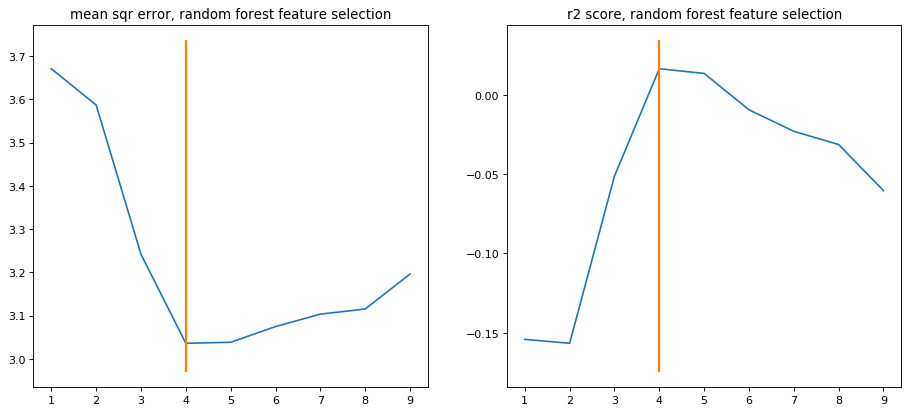

In [527]:
import matplotlib.pyplot as plt
import numpy as np

performance = performance_step_for
mse = [i[0] for i in performance]
r2 = [i[1] for i in performance]

plt.clf()
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(range(1,nrFeatures, step),[i[0] for i in performance])
plt.title('mean sqr error, random forest feature selection')
Min, Max = max(mse), min(mse)
Min, Max = Min-(Max-Min)/10, Max+(Max-Min)/10
min_index = mse.index(min(mse))+1
plt.plot([min_index, min_index], [Min, Max], linewidth=2)

plt.subplot(1,2,2)
plt.plot(range(1,nrFeatures, step),[i[1] for i in performance])
plt.title('r2 score, random forest feature selection')
Min, Max = max(r2), min(r2)
Min, Max = Min-(Max-Min)/10, Max+(Max-Min)/10
min_index = r2.index(max(r2))+1
plt.plot([min_index, min_index], [Min, Max], linewidth=2)


plt.show()



10


<Figure size 432x288 with 0 Axes>

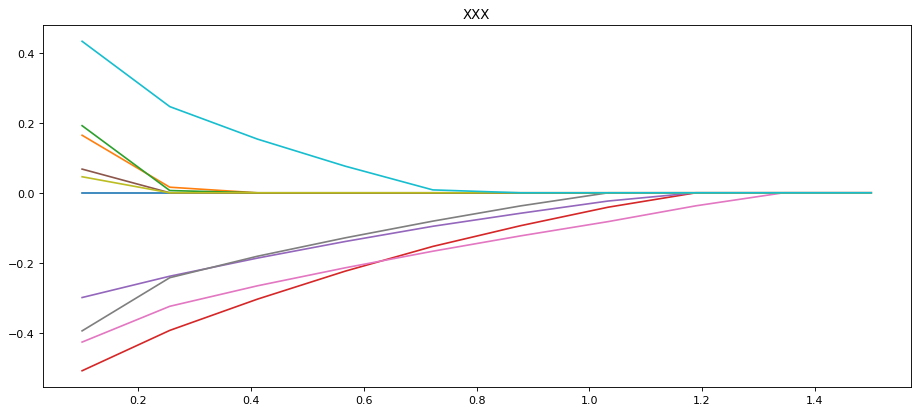

In [615]:
import matplotlib.pyplot as plt
import numpy as np

nrFeatures = xData.shape[1]
print(nrFeatures)
steps = 10
Alpha = np.linspace(0.1,1.5,steps)
coef = elastic_net(xData,yData,Alpha, 0.5)
plt.clf()
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

for i in range(nrFeatures): 
    plt.plot(Alpha,[c[i] for c in coef])
    plt.title('XXX')

